# XGBoost Based F1 Podium Predictor


In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
import shap
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
import xgboost as xgb
from xgboost import plot_tree
from xgboost import plot_importance, to_graphviz
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from IPython.display import display



## Pre-Modeling Observation
The following code uses a modified dataframe from F1 Races 2000-2024.csv with columns "Top 3 Finish", "date", "laps", "statusId", and "points" removed to prevent data leakage. These features are determined after the race is finished so the model should not see them so it can accurately determine the podium before the race starts. The code generates pre-modeling observations to show correlations between data in visuals to foreshadow what features XGBoost chooses.

Total Explained Varience Ratio: 0.5060276336766613


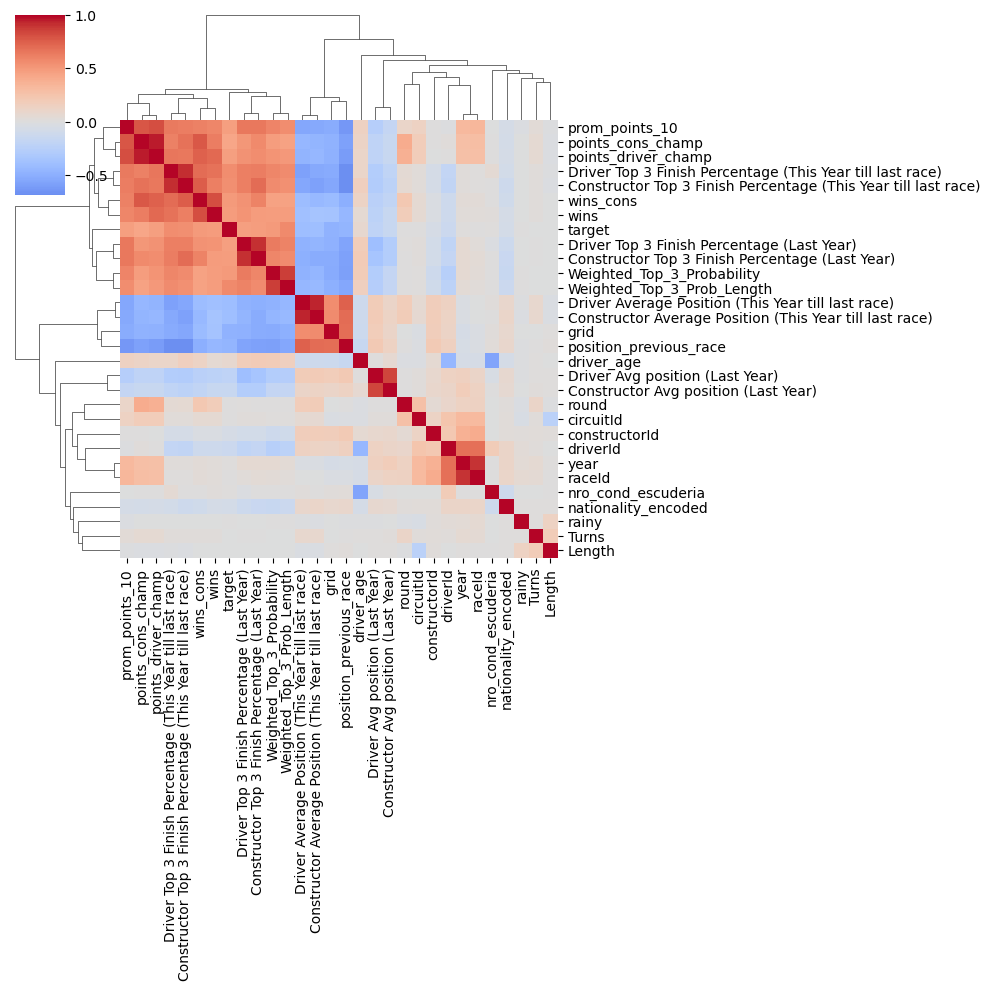

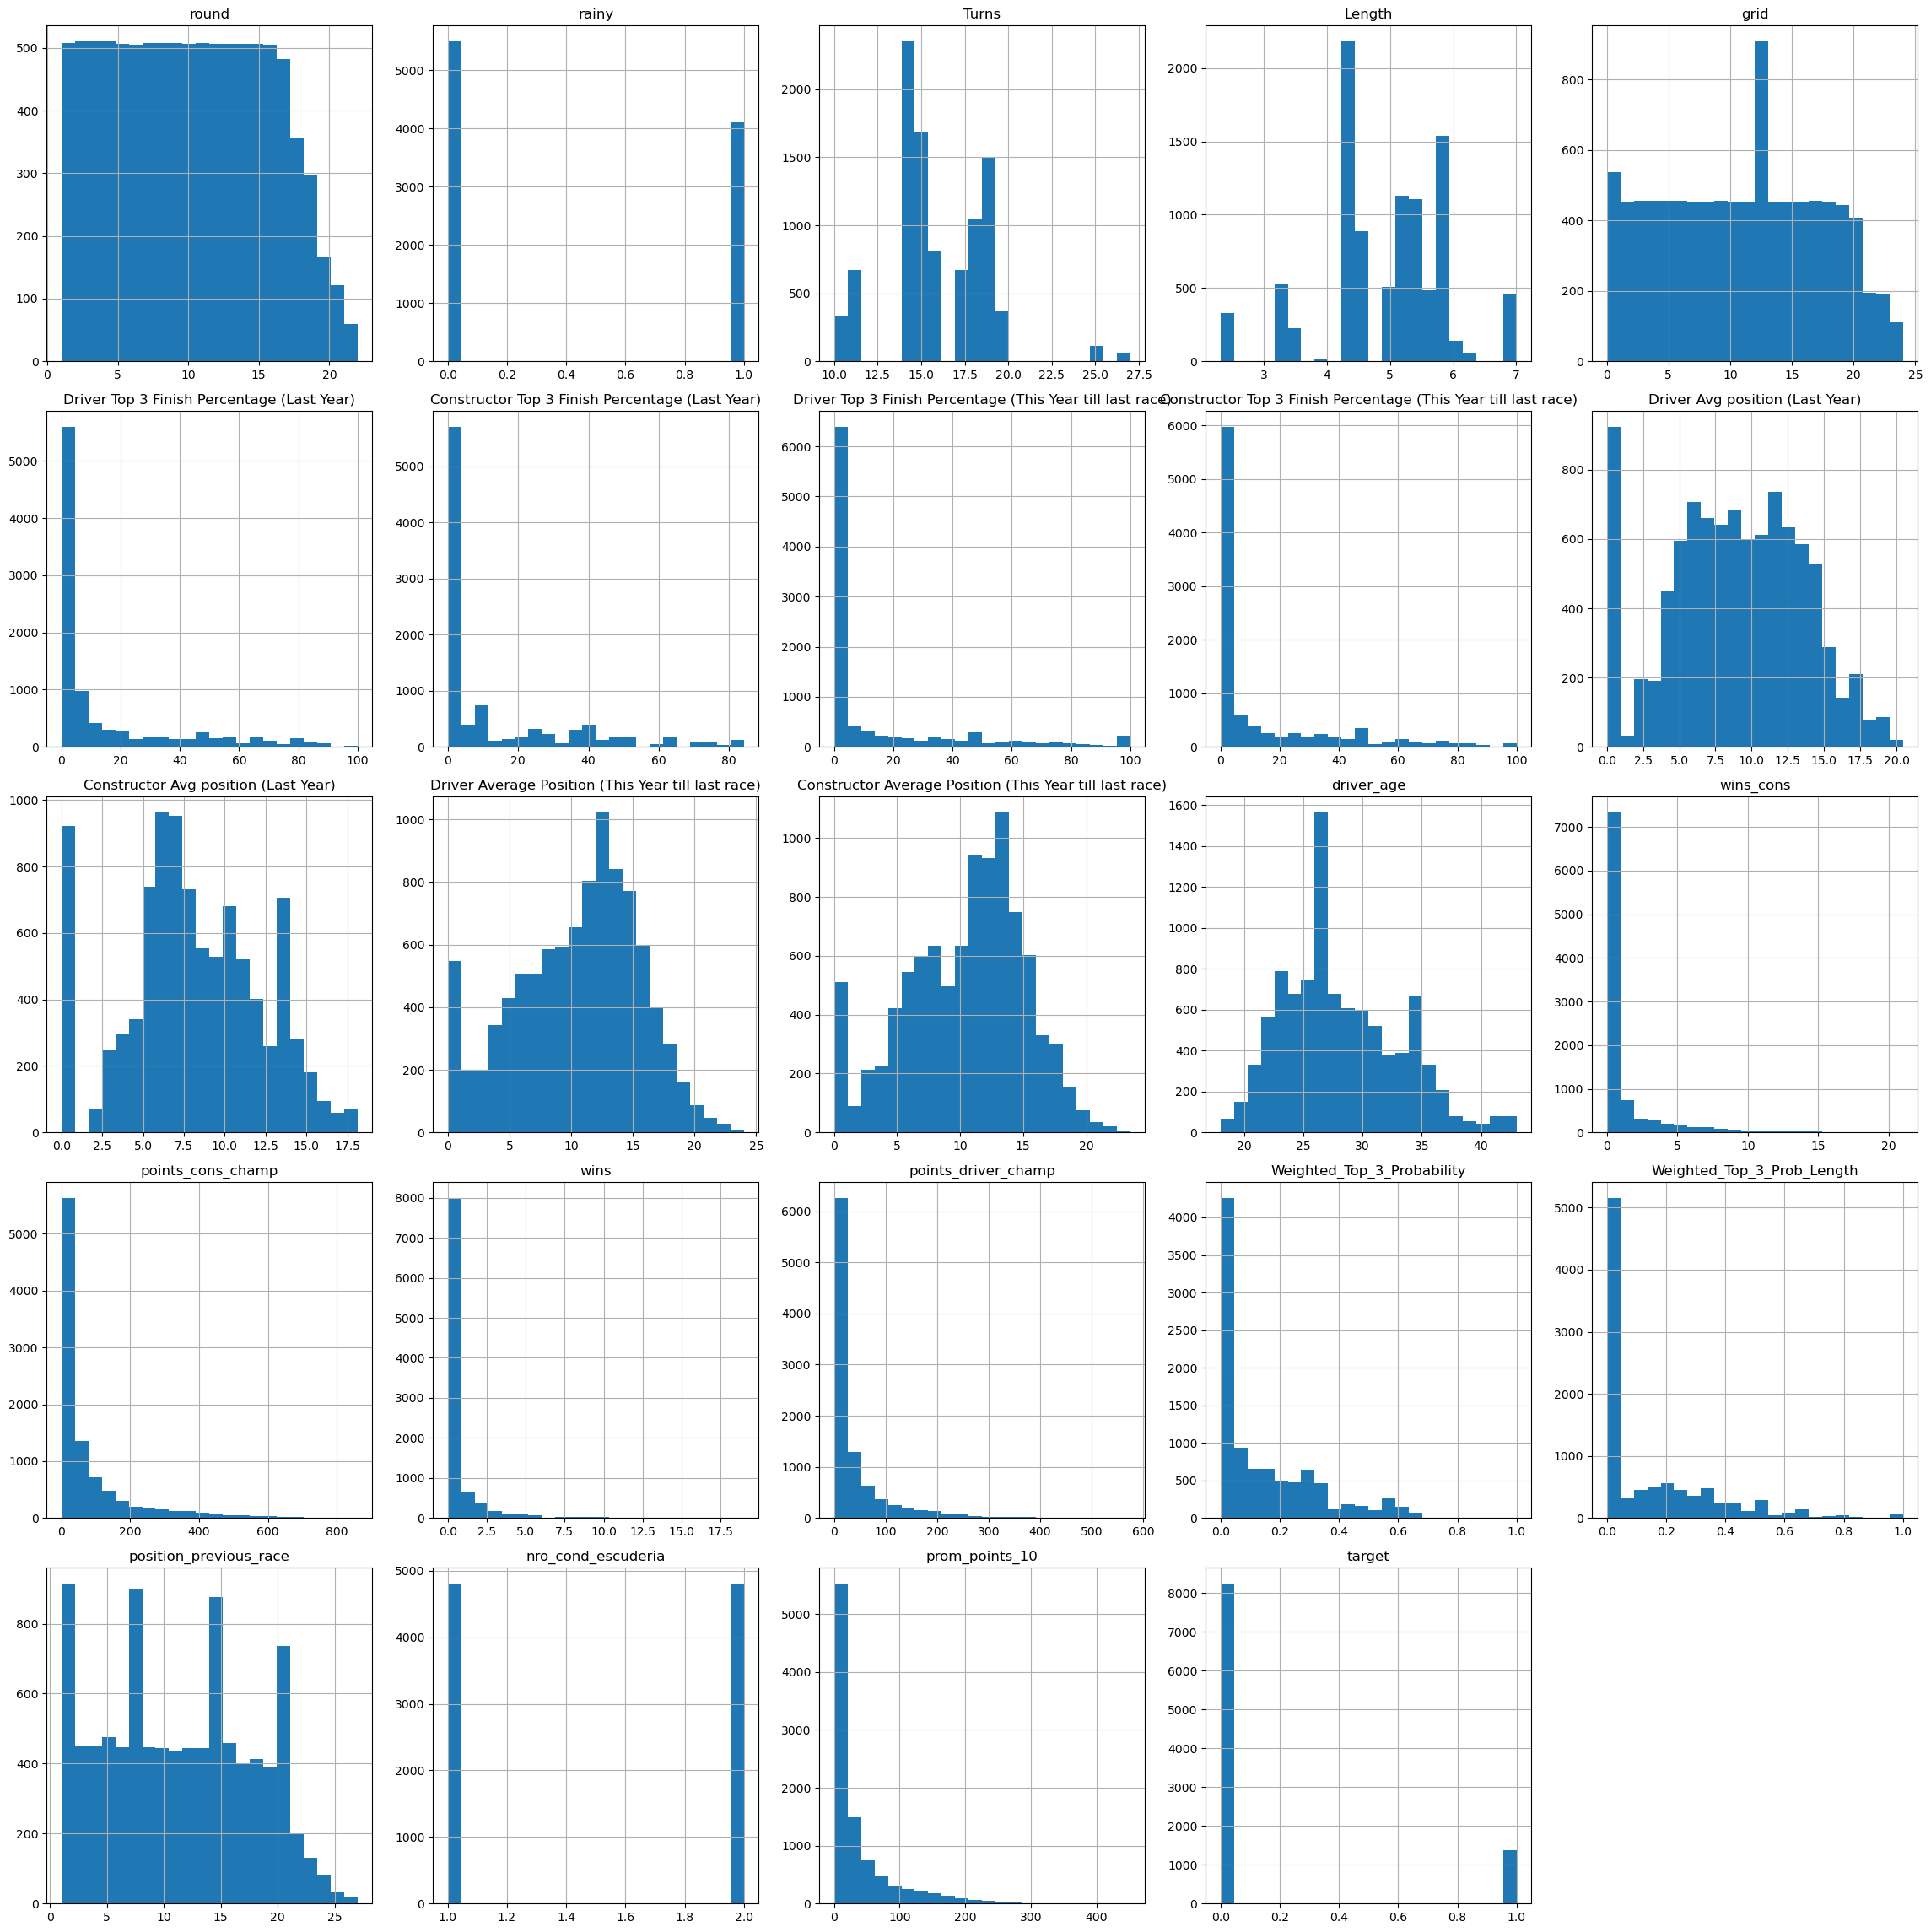

In [2]:
# Loading f1 data and cleaning
full_df = pd.read_csv("/Users/elvisgjelaj/Desktop/f1_top_predictor/F1 Races 2020-2024.csv")

# Train on 2000-2023, test on 2024
train_df = full_df[(full_df["year"] >= 2000) & (full_df["year"] <= 2023)].copy()
test_df = full_df[full_df["year"] == 2024].copy()

y = train_df["Top 3 Finish"].astype(int)

# prevents data leakage
rem_cols = ["Top 3 Finish", "date", "laps", "statusId", "points"]


def prepare_features(df, drop_cols, feature_columns=None):
    X = df.drop(columns=[col for col in drop_cols if col in df.columns], errors="ignore").copy()

    # Expand datetime columns to numeric parts
    for col in X.select_dtypes(include=["datetime", "datetimetz"]).columns:
        X[f"{col}_year"] = X[col].dt.year
        X[f"{col}_month"] = X[col].dt.month
        X[f"{col}_day"] = X[col].dt.day
        X = X.drop(columns=[col])

    # Convert object/category columns to numeric automatically
    for col in X.select_dtypes(include=["object", "category"]).columns:
        as_datetime = pd.to_datetime(X[col], errors="coerce")

        # If it looks like a date column, extract numeric parts
        if as_datetime.notna().any():
            X[f"{col}_year"] = as_datetime.dt.year
            X[f"{col}_month"] = as_datetime.dt.month
            X[f"{col}_day"] = as_datetime.dt.day
            X = X.drop(columns=[col])
        else:
            X[col] = pd.to_numeric(X[col], errors="coerce")

    X = X.apply(pd.to_numeric, errors="coerce").fillna(0)

    # Keep feature schema consistent between train and test
    if feature_columns is not None:
        X = X.reindex(columns=feature_columns, fill_value=0)

    return X


X_df = prepare_features(train_df, rem_cols)

# Generates Correlation Heatmap
df = X_df.copy()
df["target"] = y

sns.clustermap(df.corr(), cmap="coolwarm", center=0)

# Generates Feature Distribution plots excluding useless ones for histograms
rem_for_hist = [
    "circuitId",
    "raceId",
    "driverId",
    "constructorId",
    "nationality_encoded",
    "year"
]
hist_df = df.drop(columns=[col for col in rem_for_hist if col in df.columns])

hist_df.hist(figsize=(23,23), bins=22)
plt.tight_layout()

# Generates 3D PCA with standardized features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_df)

pca = PCA(n_components=3)
X_pca = pca.fit_transform(X_scaled)

print("Total Explained Varience Ratio:", pca.explained_variance_ratio_.sum())

df_pca = pd.DataFrame({
    "PC1": X_pca[:,0],
    "PC2": X_pca[:,1],
    "PC3": X_pca[:,2],
    "target": y
})

fig = px.scatter_3d(
    df_pca,
    x="PC1",
    y="PC2",
    z="PC3",
    color="target",
    opacity=0.7,
    title="Interactive 3D PCA Plot"
)

fig.show()




## XGBoost Training
The following code simply passes the dataframe data 

In [3]:
#Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X_df, y, test_size=0.2, random_state= 42)

# Final safeguard: ensure XGBoost only gets numeric/bool/category-compatible columns
def sanitize_for_xgboost(df):
    out = df.copy()
    for col in out.select_dtypes(include=["object", "datetime", "datetimetz"]).columns:
        out[col] = pd.to_numeric(out[col], errors="coerce")
    return out.apply(pd.to_numeric, errors="coerce").fillna(0)

X_train = sanitize_for_xgboost(X_train)
X_test = sanitize_for_xgboost(X_test)

# Simple XGBoost model
model = XGBClassifier(
    n_estimators = 100, #100 trees
    max_depth = 5, # max depth a tree can be
    learning_rate = 0.1, # stepsize when doing GD
    subsample = 0.8, # only gonna use randomly selected 80% of rows for each tree
    colsample_bytree = 0.8, #only gonna use randomly selected 80% of cols for each tree
    random_state = 42, #starting point for pseudorandomness
)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))



Accuracy: 0.9244791666666666


## Observation plots
The following code plots:
* A Feature importance plot that showcases which features the XGBoost model saw as the most important in making prediction.
* I also shocases the first tree the model makes and the decisisons it makes at each node and the value contribution the leaves make to the prediction function (XGBoost uses prediction function
by using the values of all leaves it goes to in each tree and uses the to make a predition).
* It includes plots for shap values that showcase how each of the 5 features contribute prediction by visualizing their shap values at 
each row (keep in mind, for those in dark mode for VS Code, .force_plot with all shap values can't be changed to having a white background and isn't supported with matplotlib=True as of Nov 20 2025)

<Figure size 900x600 with 0 Axes>

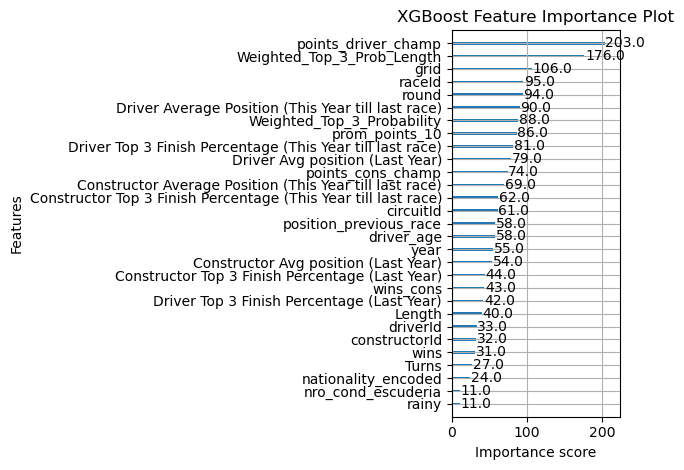

/opt/miniconda3/envs/f1_finish/lib/python3.11/site-packages/xgboost/plotting.py:267: FutureWarning:

The `num_trees` parameter is deprecated, use `tree_idx` insetad. 



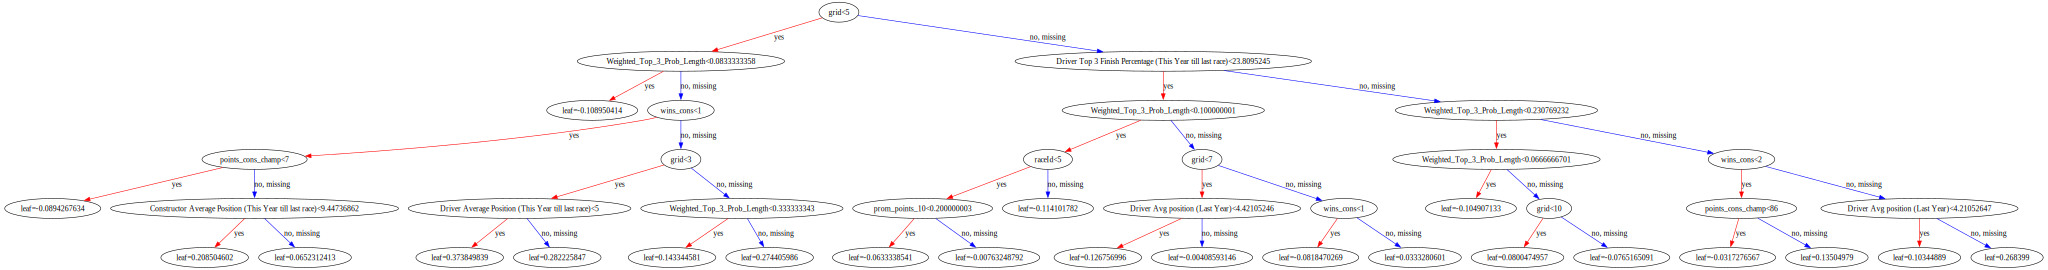

In [4]:
# Feature importance plot
plt.figure(figsize=(9, 6))
plot_importance(model)
plt.title("XGBoost Feature Importance Plot")
plt.tight_layout()
plt.show()

# Plots the first tree 
dot = to_graphviz(model, num_trees=1)

display(dot)


# Plots SHAP values for the features
shap.initjs()
explainer = shap.TreeExplainer(model)
shap_values = explainer(X_df)
#shap.plots.heatmap(shap_values)
#shap.plots.waterfall(shap_values[0])
# shap.force_plot(shap_values[0])
shap.force_plot(shap_values[0: 9840: 50])



In [5]:
# 2024 podium prediction + decoded output in one cell
X_2024 = prepare_features(test_df, rem_cols, feature_columns=X_df.columns)
X_2024 = sanitize_for_xgboost(X_2024)

# Predict on prepared numeric features (not raw test_df)
predictions = model.predict(X_2024)
pred_proba = model.predict_proba(X_2024)[:, 1]

pred_df = test_df[[
    "year", "round", "raceId", "driverId", "constructorId", "Top 3 Finish"
]].copy()
pred_df["top3_probability"] = pred_proba

# Top 3 predictions per race
podium_pred = (
    pred_df.sort_values(["raceId", "top3_probability"], ascending=[True, False])
    .groupby("raceId")
    .head(3)
    .copy()
)
podium_pred["placement"] = podium_pred.groupby("raceId").cumcount() + 1

# Decode IDs from local CSV files
races_lookup = pd.read_csv("races.csv", usecols=["raceId", "name"]).rename(columns={"name": "location"})

drivers_lookup = pd.read_csv("drivers.csv", usecols=["driverId", "forename", "surname"])
drivers_lookup["driver"] = (
    drivers_lookup["forename"].fillna("") + " " + drivers_lookup["surname"].fillna("")
).str.strip()
drivers_lookup = drivers_lookup[["driverId", "driver"]]

constructors_lookup = pd.read_csv("constructors.csv", usecols=["constructorId", "name"]).rename(
    columns={"name": "constructor"}
)

# Final row-level output
final_output = (
    podium_pred
    .merge(races_lookup, on="raceId", how="left")
    .merge(drivers_lookup, on="driverId", how="left")
    .merge(constructors_lookup, on="constructorId", how="left")
    .assign(prediction=lambda df: np.where(df["Top 3 Finish"].astype(int).eq(1), "right", "wrong"))
    [["year", "round", "location", "driver", "constructor", "placement", "prediction"]]
    .sort_values(["year", "round", "placement"])
    .reset_index(drop=True)
)

print("2024 podium predictions:")
print(final_output.to_string(index=False, line_width=2000))

# Driver + constructor summary: predicted vs actual P1/P2/P3 counts
pred_counts = (
    final_output.groupby(["driver", "constructor", "placement"]).size().unstack(fill_value=0)
    .reindex(columns=[1, 2, 3], fill_value=0)
    .rename(columns={1: "pred_p1", 2: "pred_p2", 3: "pred_p3"})
    .reset_index()
)

actual_position_col = next(
    (c for c in ["positionOrder", "position", "final_position", "placement"] if c in test_df.columns),
    None,
)

actual_base = (
    test_df[["driverId", "constructorId", "Top 3 Finish"] + ([actual_position_col] if actual_position_col else [])]
    .merge(drivers_lookup, on="driverId", how="left")
    .merge(constructors_lookup, on="constructorId", how="left")
)

if actual_position_col is not None:
    actual_base[actual_position_col] = pd.to_numeric(actual_base[actual_position_col], errors="coerce")
    actual_counts = (
        actual_base[actual_base[actual_position_col].between(1, 3)]
        .groupby(["driver", "constructor", actual_position_col])
        .size()
        .unstack(fill_value=0)
        .reindex(columns=[1, 2, 3], fill_value=0)
        .rename(columns={1: "actual_p1", 2: "actual_p2", 3: "actual_p3"})
        .reset_index()
    )
else:
    actual_counts = (
        actual_base[actual_base["Top 3 Finish"].astype(int).eq(1)]
        .groupby(["driver", "constructor"]).size()
        .rename("actual_top3_total")
        .reset_index()
    )
    actual_counts["actual_p1"] = np.nan
    actual_counts["actual_p2"] = np.nan
    actual_counts["actual_p3"] = np.nan

comparison_table = (
    pred_counts
    .merge(actual_counts[["driver", "constructor", "actual_p1", "actual_p2", "actual_p3"] + (["actual_top3_total"] if "actual_top3_total" in actual_counts.columns else [])],
           on=["driver", "constructor"], how="outer")
    .fillna(0)
)

for col in ["pred_p1", "pred_p2", "pred_p3", "actual_p1", "actual_p2", "actual_p3"]:
    comparison_table[col] = comparison_table[col].astype(int)

comparison_table = comparison_table.sort_values(["driver", "constructor"]).reset_index(drop=True)

print("\nDriver/constructor placements: predicted vs actual")
if actual_position_col is None:
    print("(Actual P1/P2/P3 not available in this dataset; showing predicted P1/P2/P3 and actual_top3_total.)")

out_cols = ["driver", "constructor", "pred_p1", "actual_p1", "pred_p2", "actual_p2", "pred_p3", "actual_p3"]
if "actual_top3_total" in comparison_table.columns:
    out_cols.append("actual_top3_total")

print(comparison_table[out_cols].to_string(index=False, line_width=2000))





2024 podium predictions:
 year  round                  location          driver  constructor  placement prediction
 2024      1        Bahrain Grand Prix  Max Verstappen     Red Bull          1      right
 2024      1        Bahrain Grand Prix    Carlos Sainz      Ferrari          2      right
 2024      1        Bahrain Grand Prix    Sergio Pérez     Red Bull          3      right
 2024      2  Saudi Arabian Grand Prix  Max Verstappen     Red Bull          1      right
 2024      2  Saudi Arabian Grand Prix Charles Leclerc      Ferrari          2      right
 2024      2  Saudi Arabian Grand Prix    Sergio Pérez     Red Bull          3      right
 2024      3     Australian Grand Prix  Max Verstappen     Red Bull          1      wrong
 2024      3     Australian Grand Prix    Carlos Sainz      Ferrari          2      right
 2024      3     Australian Grand Prix Charles Leclerc      Ferrari          3      right
 2024      4       Japanese Grand Prix  Max Verstappen     Red Bull        

In [6]:
# Podium tally per driver: predicted vs actual (2024), including zero/zero rows

# Decode IDs for all 2024 driver-constructor pairs
drivers_lookup_actual = pd.read_csv("drivers.csv", usecols=["driverId", "forename", "surname"])
drivers_lookup_actual["driver"] = (
    drivers_lookup_actual["forename"].fillna("") + " " + drivers_lookup_actual["surname"].fillna("")
).str.strip()
drivers_lookup_actual = drivers_lookup_actual[["driverId", "driver"]]

constructors_lookup_actual = pd.read_csv("constructors.csv", usecols=["constructorId", "name"]).rename(
    columns={"name": "constructor"}
)

all_2024_pairs = (
    test_df[["driverId", "constructorId"]]
    .drop_duplicates()
    .merge(drivers_lookup_actual, on="driverId", how="left")
    .merge(constructors_lookup_actual, on="constructorId", how="left")
    [["driver", "constructor"]]
    .drop_duplicates()
)

# Predicted podium totals from model output
predicted_podiums = (
    final_output.groupby(["driver", "constructor"]).size()
    .rename("predicted_podiums")
    .reset_index()
)

# Actual podium totals from 2024 results
actual_podiums = (
    test_df[test_df["Top 3 Finish"].astype(int).eq(1)][["driverId", "constructorId"]]
    .merge(drivers_lookup_actual, on="driverId", how="left")
    .merge(constructors_lookup_actual, on="constructorId", how="left")
    .groupby(["driver", "constructor"]).size()
    .rename("actual_podiums")
    .reset_index()
)

# Final comparison table (includes drivers with 0 predicted and 0 actual)
podium_tally = (
    all_2024_pairs
    .merge(predicted_podiums, on=["driver", "constructor"], how="left")
    .merge(actual_podiums, on=["driver", "constructor"], how="left")
    .fillna(0)
)

podium_tally["predicted_podiums"] = podium_tally["predicted_podiums"].astype(int)
podium_tally["actual_podiums"] = podium_tally["actual_podiums"].astype(int)

podium_tally["prediction_to_actual_ratio"] = np.where(
    podium_tally["actual_podiums"].eq(0),
    np.nan,
    (podium_tally["predicted_podiums"] / podium_tally["actual_podiums"]).round(2)
)

podium_tally = podium_tally.sort_values(["actual_podiums", "predicted_podiums", "driver"], ascending=[False, False, True]).reset_index(drop=True)

print("Driver podium tally (predicted vs actual):")
print(podium_tally[["driver", "constructor", "predicted_podiums", "actual_podiums", "prediction_to_actual_ratio"]].to_string(index=False, line_width=2000))




Driver podium tally (predicted vs actual):
          driver    constructor  predicted_podiums  actual_podiums  prediction_to_actual_ratio
  Max Verstappen       Red Bull                 11               9                        1.22
    Lando Norris        McLaren                  7               7                        1.00
 Charles Leclerc        Ferrari                  6               5                        1.20
    Carlos Sainz        Ferrari                  4               5                        0.80
    Sergio Pérez       Red Bull                  3               4                        0.75
  Lewis Hamilton       Mercedes                  2               2                        1.00
  George Russell       Mercedes                  1               2                        0.50
   Oscar Piastri        McLaren                  1               2                        0.50
 Fernando Alonso   Aston Martin                  1               0                         NaN
 Alexan